# Clustering Text (Text Mining)

Clustering dapat digunakan untuk membantu
menganalisis berita dengan **mengelompokkan secara otomatis**
berita yang memiliki kesamaan atau kemiripan. Sebuah
cluster adalah sekumpulan objek yang digabung bersama
karena persamaan atau kedekatannya [1]. Clustering termasuk
dalam teknik **unsupervised learning** dimana tidak memerlukan
fase training [2]. 

**[1] Herny Februariyanti Dan Dwi Budi Santoso, 2017, “Hierarchical
Agglomerative Clustering Untuk Pengelompokan Skripsi Mahasiswa,”
Prosiding SINITAK 2017, ISBN: 978-602-8557-20-7.**


**[2] Pivin Suwrmayanti, I Ketut Gede Darma Putra, I Nyoman Satya
Kumara, ”Optimasi Pusat Cluster K-Prototype dengan Algoritma
Genetika,” Teknologi Elektro, Vol. 13 No. 2 Juli-Desember 2014.**

## Import Module

In [186]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import re
import preprocessor as p

from wordcloud import WordCloud

In [187]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags
from gensim.models.doc2vec import TaggedDocument

# doc: document text string
# returns tokenized document
# strip_tags removes meta tags from the text
# simple preprocess converts a document into a list of lowercase tokens, ignoring tokens that are too short or too long 
# simple preprocess also removes numerical values as well as punktuation characters
def tokenize(doc):
    return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)

In [188]:
import os
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

In [189]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

In [190]:
#Import Module
from lbl2vec import Lbl2Vec

## DATASET

Data yang digunakan merupakan **data history pelatihan yang ada di perusahaan X**

**Tujuan dari research** ini adalah memetakan nama pelatihan sesuai dengan chapter yang ada

In [191]:
df_dataset = pd.read_csv('/Users/irvanzidny/Downloads/dataset_pelatihan.csv',sep=";")

In [192]:
df_dataset.head()

,nama_pelatihan,objid_pelatihan,CFU/FU,category,type,lokasi_pelatihan,provider,academy_event,lokasi,provider_category,...,ubpp_sarana,ubpp_laborat,ubpp_penyelenggaraan,ubpp_kafetaria,ubpp_materi,net_promotor_score,customer_satisfaction,first_respon_and_average_handling,customer_effort_score,tipe
0,Swift Advanced,80116897,DIGITAL FACING UNIT-DIGITAL BUSINESS,LAT,E-learning,Bandung,Learning Area 3 Bandung,DSP,Online (Lokasi Masing-Masing),Internal,...,0,0,0,0,0,0,0,0,0,train
1,Business Management,80117127,DIGITAL FACING UNIT-DIGITAL BUSINESS,LAT,E-learning,Bandung,Learning Area 3 / LO Bandung,DSP,Online (Lokasi Masing-Masing),Internal,...,0,0,0,0,0,0,0,0,0,train
2,AWS Cloud Practitioner Essentials,80117041,DIGITAL FACING UNIT-DIGITAL BUSINESS,LAT,Virtual Classroom,Bandung,Learning Area 3 Bandung,NITS,Online (Lokasi Masing-Masing),Internal,...,100,0,96,100,"97,5",100,98,100,96,train
3,Digital Product Management,80116986,DIGITAL FACING UNIT-DIGITAL BUSINESS,LAT,E-learning,Bandung,Learning Area 3 / LO Bandung,DSP,Online (Lokasi Masing-Masing),Internal,...,100,0,100,0,100,100,100,100,100,train
4,Head of Data,80117053,DIGITAL FACING UNIT-DIGITAL BUSINESS,LAT,Virtual Classroom,Bandung,Learning Area 7 Makassar,DSP,Online (Lokasi Masing-Masing),Internal,...,92,0,"95,6",0,"95,5",80,"94,67",96,"95,2",train


In [193]:
df_dataset.dropna(inplace = True)

In [194]:
#from pandas_profiling import ProfileReport as report
#profile = report(df_dataset)
#profile.to_notebook_iframe()

In [195]:
# custum function to clean the dataset (combining tweet_preprocessor and reguar expression)
def clean_tweets(df_dataset):
    #set up punctuations we want to be replaced
    REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})|(\&)")
    REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")
    tempArr = []
    for line in df_dataset:
        # send to tweet_processor
        tmpL = p.clean(line)
        # remove puctuation
        tmpL = REPLACE_NO_SPACE.sub("", tmpL.lower()) # convert all tweets to lower cases
        tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
        tempArr.append(tmpL)
    return tempArr

In [196]:
df_dataset['nama_pelatihan'] = clean_tweets(df_dataset['nama_pelatihan'])
df_dataset['nama_pelatihan'] = df_dataset['nama_pelatihan'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_dataset['nama_pelatihan'] = df_dataset['nama_pelatihan'].str.strip()
df_dataset.head()

,nama_pelatihan,objid_pelatihan,CFU/FU,category,type,lokasi_pelatihan,provider,academy_event,lokasi,provider_category,...,ubpp_sarana,ubpp_laborat,ubpp_penyelenggaraan,ubpp_kafetaria,ubpp_materi,net_promotor_score,customer_satisfaction,first_respon_and_average_handling,customer_effort_score,tipe
0,swift advanced,80116897,DIGITAL FACING UNIT-DIGITAL BUSINESS,LAT,E-learning,Bandung,Learning Area 3 Bandung,DSP,Online (Lokasi Masing-Masing),Internal,...,0,0,0,0,0,0,0,0,0,train
1,business management,80117127,DIGITAL FACING UNIT-DIGITAL BUSINESS,LAT,E-learning,Bandung,Learning Area 3 / LO Bandung,DSP,Online (Lokasi Masing-Masing),Internal,...,0,0,0,0,0,0,0,0,0,train
2,aws cloud practitioner essentials,80117041,DIGITAL FACING UNIT-DIGITAL BUSINESS,LAT,Virtual Classroom,Bandung,Learning Area 3 Bandung,NITS,Online (Lokasi Masing-Masing),Internal,...,100,0,96,100,"97,5",100,98,100,96,train
3,digital product management,80116986,DIGITAL FACING UNIT-DIGITAL BUSINESS,LAT,E-learning,Bandung,Learning Area 3 / LO Bandung,DSP,Online (Lokasi Masing-Masing),Internal,...,100,0,100,0,100,100,100,100,100,train
4,head data,80117053,DIGITAL FACING UNIT-DIGITAL BUSINESS,LAT,Virtual Classroom,Bandung,Learning Area 7 Makassar,DSP,Online (Lokasi Masing-Masing),Internal,...,92,0,"95,6",0,"95,5",80,"94,67",96,"95,2",train


In [197]:
corpus = list(df_dataset['nama_pelatihan'])
corpus_embeddings = embedder.encode(corpus, convert_to_numpy=True, show_progress_bar=True)
corpus_embeddings

Batches: 100%|██████████| 12/12 [00:18<00:00,  1.58s/it]


array([[-0.41908675, -0.5485679 ,  1.7648611 , ..., -0.5255295 ,
        -0.5036792 ,  0.07134763],
       [-0.30133283,  0.41961932,  1.2215854 , ..., -0.8016323 ,
        -1.112569  , -0.0852531 ],
       [ 0.09550718,  0.20906094,  1.8288566 , ..., -0.48715284,
        -0.98204684, -0.30654863],
       ...,
       [-0.693476  , -0.18322594,  1.6008664 , ..., -0.6969384 ,
        -0.5564684 ,  0.29290274],
       [-0.5622968 ,  0.7641607 ,  1.0904896 , ..., -1.2543405 ,
        -0.87380725,  0.43681574],
       [-0.21194506, -0.38583776,  1.8784606 , ..., -1.0729183 ,
        -0.604047  ,  0.22274725]], dtype=float32)

In [198]:
num_clusters = 6
clustering_model = KMeans(n_clusters= num_clusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=154, copy_x=True, algorithm='auto')
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

In [199]:
cluster_assignment

array([0, 2, 5, 3, 5, 0, 0, 2, 0, 0, 4, 3, 3, 4, 0, 1, 1, 0, 1, 2, 1, 2,
       5, 5, 2, 1, 2, 5, 4, 1, 3, 1, 3, 1, 0, 0, 3, 4, 0, 3, 2, 1, 3, 1,
       4, 3, 1, 5, 3, 3, 3, 4, 4, 0, 5, 5, 4, 2, 5, 4, 5, 1, 1, 5, 5, 0,
       5, 3, 0, 0, 4, 4, 3, 3, 3, 2, 4, 0, 5, 2, 3, 3, 4, 4, 0, 0, 1, 4,
       0, 0, 5, 1, 5, 1, 0, 5, 3, 1, 3, 3, 1, 2, 1, 3, 3, 1, 1, 5, 4, 3,
       3, 5, 3, 5, 0, 0, 0, 5, 4, 0, 4, 1, 3, 5, 3, 0, 0, 0, 3, 3, 5, 3,
       1, 2, 0, 0, 4, 2, 0, 0, 0, 3, 5, 5, 5, 0, 4, 4, 5, 4, 0, 1, 4, 5,
       4, 4, 2, 5, 0, 4, 3, 0, 0, 0, 0, 0, 1, 0, 5, 3, 5, 5, 5, 1, 0, 5,
       1, 0, 1, 5, 2, 5, 4, 4, 5, 1, 3, 3, 1, 1, 5, 1, 3, 1, 5, 4, 0, 5,
       3, 5, 5, 3, 2, 0, 3, 5, 0, 0, 4, 5, 2, 2, 0, 2, 1, 1, 2, 0, 1, 3,
       1, 0, 1, 3, 3, 3, 5, 1, 1, 1, 3, 4, 1, 4, 4, 0, 5, 0, 2, 5, 5, 3,
       4, 4, 5, 0, 4, 1, 1, 0, 5, 4, 5, 5, 4, 0, 0, 5, 4, 4, 5, 3, 2, 0,
       2, 2, 0, 3, 5, 0, 2, 5, 2, 2, 5, 5, 4, 5, 3, 4, 1, 4, 2, 2, 0, 3,
       5, 0, 2, 0, 1, 0, 3, 2, 5, 4, 5, 0, 5, 5, 0,

In [200]:
cluster_df = pd.DataFrame(corpus, columns = ['nama_pelatihan'])
cluster_df['cluster'] = cluster_assignment
cluster_df.head()

,nama_pelatihan,cluster
0,swift advanced,0
1,business management,2
2,aws cloud practitioner essentials,5
3,digital product management,3
4,head data,5


In [201]:
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['swift advanced', 'strategic leadershp mgt specialization', 'user research methods best practice', 'data driven product growth', 'design thinking ultimate guide', 'advanced product management', 'become prodmgr learn skill get job', 'advanced product management', 'unlock innovation user centricity', 'become product manager', 'product innovation management', 'data driven product growth', 'monetization strategy course', 'activation retention strategy', 'go market strategy', 'product management dxb dpm', 'lean ux agile', 'recommendtion engine using deep learning', 'deep learning', 'customer journey mapping miro', 'front end developer expert', 'effective ideation techniques ux des', 'product management sharing session', 'discoveries building right thing', 'supply chain strategy procurement', 'insight innovation', 'user experience research design', 'agile process project program cont', 'seo course', 'become product manager', 'product management', 'go practice', 'experience design

In [202]:
#word cloud
def word_cloud(pred_df,label):
    wc = ' '.join([text for text in pred_df['nama_pelatihan'][pred_df['cluster'] == label]])
    wordcloud = WordCloud(width=800, height=500,
    random_state=21, max_font_size=110).generate(wc)
    fig7 = plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

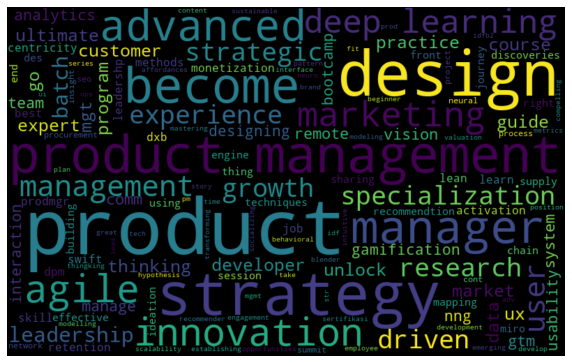

In [203]:
word_cloud(cluster_df,0)

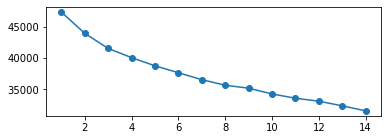

In [204]:
##### Inertia error method
cluster_range = range( 1, 15 )
cluster_errors = []
for num_clusters in cluster_range:
   clusters = KMeans( num_clusters )
   clusters.fit( corpus_embeddings )
   cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

plt.figure(figsize=(6,2))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

**Kesimpulan**

Dapat dikatakan bahwa data yang digunakan merupakan data yang sangat random dan masing-masing memiliki **charac yang berbeda, sehingga machine kesulitan dalam mengkategorisasikan**. Tetapi untuk saat ini hasil yang dihasilkan menunjukkan adanya kategori yang memungkinkan seperti pada **business and management, data science, developer, designer, probis CX**

# TAHAP EKSPLORASI

## Text Simmilarity (Text Mining)

Text Similarity adalah suatu ukuran yang menggambarkan **tingkat kemiripan antara satu teks dengan teks lainnya**. Teks dapat terdiri dari beberapa kata, namun dapat pula terdiri dari milyaran kata yang tertulis
dalam sebuah naskah. Secara umum, terdapat dua kategori cara untuk mengukur hal tesebut.

In [205]:
#Import Module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## CDMP Dataset

In [206]:
cdmp_dataset = pd.read_csv('/Users/irvanzidny/Downloads/cdmp_dataset.csv',sep=";")
cdmp_dataset.head()

,school,lp_id,learning_pathway,slp_id,sub_learning_pathway,sslp_id,sub2_learning_pathway,course_id,course_name
0,SoDPS,DPS.1,Data Science,DPS.1.1,Math & Statistics,DPS.1.1.A,Mathematics,DPS.1.1.A.1,Introduction to Discrete Mathematics for Compu...
1,SoDPS,DPS.1,Data Science,DPS.1.1,Math & Statistics,DPS.1.1.A,Mathematics,DPS.1.1.A.2,Mathematics for Machine Learning Specialization
2,SoDPS,DPS.1,Data Science,DPS.1.1,Math & Statistics,DPS.1.1.A,Mathematics,DPS.1.1.A.3,Mathematics for Data Science Specialization
3,SoDPS,DPS.1,Data Science,DPS.1.1,Math & Statistics,DPS.1.1.B,Statistics,DPS.1.1.B.1,Statistics and Probability
4,SoDPS,DPS.1,Data Science,DPS.1.1,Math & Statistics,DPS.1.1.B,Statistics,DPS.1.1.B.2,Business Statistics and Analysis Specialization


In [207]:
cdmp_dataset.dropna(inplace=True)

In [208]:
#from pandas_profiling import ProfileReport as report
#profile2 = report(cdmp_dataset)
#profile2.to_notebook_iframe()

Text Simillarity akan diambil berdasarkan kemiripan antara couse_name dengan learning program yang pernah dijalankan pada tahun 2021

In [209]:
# Custom function to clean the dataset (combining preprocessor and regular exporession)
def clean(cdmp_dataset):
    #set up punctuation we want to be replace
    REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})|(\&)")
    REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")
    #Create array temporary
    tempArr = []
    for line in cdmp_dataset:
        #send to processor
        tmpL = p.clean(line)
        #remove punctuation
        tmpL = REPLACE_NO_SPACE.sub("", tmpL.lower()) #convert all to lower cases
        tmpL = REPLACE_WITH_SPACE.sub(" ",tmpL)
        tempArr.append(tmpL)
    return tempArr


In [210]:
cdmp_dataset['course_name'] = clean(cdmp_dataset['course_name'])
cdmp_dataset['course_name'] = cdmp_dataset['course_name'].apply(lambda x: ' '.join([word for word in x.split() if word not in(stop)]))
cdmp_dataset['course_name'] = cdmp_dataset['course_name'].str.strip()
cdmp_dataset.head()

,school,lp_id,learning_pathway,slp_id,sub_learning_pathway,sslp_id,sub2_learning_pathway,course_id,course_name
0,SoDPS,DPS.1,Data Science,DPS.1.1,Math & Statistics,DPS.1.1.A,Mathematics,DPS.1.1.A.1,introduction discrete mathematics computer sci...
1,SoDPS,DPS.1,Data Science,DPS.1.1,Math & Statistics,DPS.1.1.A,Mathematics,DPS.1.1.A.2,mathematics machine learning specialization
2,SoDPS,DPS.1,Data Science,DPS.1.1,Math & Statistics,DPS.1.1.A,Mathematics,DPS.1.1.A.3,mathematics data science specialization
3,SoDPS,DPS.1,Data Science,DPS.1.1,Math & Statistics,DPS.1.1.B,Statistics,DPS.1.1.B.1,statistics probability
4,SoDPS,DPS.1,Data Science,DPS.1.1,Math & Statistics,DPS.1.1.B,Statistics,DPS.1.1.B.2,business statistics analysis specialization


In [211]:
from sentence_transformers import SentenceTransformer, util

In [212]:
#Mengambil list kolum pelatihan 2021 dan 2022
history_pelatihan = df_dataset['nama_pelatihan']
#Mengambil catalog course
catalog_course = cdmp_dataset['course_name']

In [213]:
corpus2 = list(cdmp_dataset['course_name'])
corpus_embeddings2 = embedder.encode(corpus2, convert_to_numpy=True, show_progress_bar=True)
corpus_embeddings2

Batches: 100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


array([[-0.99969643,  0.21328503,  0.5685867 , ...,  0.01771902,
        -0.83515674,  0.94426584],
       [-1.0618099 ,  0.22729735,  0.8439308 , ..., -0.7088592 ,
        -1.1275421 ,  1.0352521 ],
       [-1.1104622 , -0.02186982,  0.64206964, ..., -0.46511492,
        -0.78136414,  0.98046845],
       ...,
       [ 0.5594617 , -1.3178546 ,  1.9063828 , ..., -0.5870715 ,
        -0.8068284 , -0.6016979 ],
       [-0.3704223 ,  0.00941978,  1.8485543 , ..., -1.405431  ,
        -1.201485  , -0.02162064],
       [ 0.20896013,  0.241176  ,  1.7746274 , ..., -0.86795914,
        -0.8187127 , -0.6723404 ]], dtype=float32)

# Check Similarity

## Cosine Similarity

Metode **Cosine Similarity** adalah mengukur kemiripan antara
dua dokumen atau teks.

In [214]:
from sklearn.metrics.pairwise import cosine_similarity
#Calculate Cosine Similarity
main = cosine_similarity(corpus_embeddings2,corpus_embeddings)


In [215]:
corr = pd.DataFrame(main, 
                    index = list(cdmp_dataset['course_name']),
                    columns = list(df_dataset['nama_pelatihan']))
corr.head()

,swift advanced,business management,aws cloud practitioner essentials,digital product management,head data,strategic leadershp mgt specialization,user research methods best practice,intranet employee experience symposium,data driven product growth,design thinking ultimate guide,...,sql data science google big query,aws certified developer associate,architect saas apps unique challenges,profdev hours iiba ecba,intro programming using javascript,objoriented analysis design programming,ccc internet things foundation cert,time series modelling deep learning,product management microsofts pm,manage remote team
introduction discrete mathematics computer science specialization,0.180976,0.360460,0.401338,0.474483,0.371763,0.331795,0.401682,0.401773,0.287802,0.363439,...,0.505356,0.312230,0.354583,0.291118,0.555110,0.606650,0.452150,0.518271,0.485058,0.380504
mathematics machine learning specialization,0.199027,0.386809,0.370091,0.475283,0.359162,0.364190,0.437411,0.408879,0.358298,0.363430,...,0.577983,0.308843,0.441500,0.277508,0.601803,0.652909,0.466391,0.583236,0.505836,0.374642
mathematics data science specialization,0.226497,0.365726,0.417759,0.472609,0.417059,0.365451,0.424791,0.366585,0.379815,0.357732,...,0.578607,0.324425,0.393152,0.282868,0.493156,0.606520,0.454826,0.485012,0.496888,0.339061
statistics probability,0.442252,0.348710,0.467451,0.469345,0.534387,0.471189,0.425076,0.323863,0.544536,0.365890,...,0.311080,0.399308,0.310630,0.469278,0.285371,0.517839,0.392325,0.432259,0.407916,0.464294
business statistics analysis specialization,0.224232,0.754747,0.428313,0.431666,0.373246,0.511396,0.438465,0.478684,0.616680,0.398900,...,0.505259,0.424375,0.397934,0.378576,0.303886,0.532011,0.405199,0.452885,0.588528,0.350751


## DOT SCORE

**Euclidean distance** adalah perhitungan jarak dari 2 buah titik dalam Euclidean space. Euclidean space diperkenalkan oleh Euclid, seorang matematikawan dari Yunani sekitar tahun 300 B.C.E

In [216]:
from sentence_transformers import SentenceTransformer, util

#Compute dot score between query and all document embeddings
main2 = util.dot_score(corpus_embeddings2, corpus_embeddings)

In [217]:
main2 = main2.detach().numpy()

In [218]:
corr3 = pd.DataFrame(main2)

In [219]:
corr3.head()

,0,1,2,3,4,5,6,7,8,9,...,360,361,362,363,364,365,366,367,368,369
0,50.521927,99.806038,105.874786,130.637589,100.137650,88.599442,111.181534,108.232162,79.437592,98.787308,...,138.863373,84.875015,95.356140,74.294197,150.346741,160.647079,119.458626,137.977325,133.135986,99.862541
1,57.232674,110.323837,100.568672,134.794418,99.653824,100.175537,124.712952,113.459839,101.870781,101.756790,...,163.597839,86.479828,122.302078,72.951584,167.896698,178.098206,126.927994,159.943878,143.015594,101.281921
2,64.511169,103.316360,112.439957,132.758545,114.615295,99.564209,119.960594,100.754257,106.959015,99.206551,...,162.213531,89.977234,107.870872,73.651871,136.273941,163.867432,122.600830,131.739532,139.146729,90.789391
3,126.360420,98.820206,126.211456,132.257614,147.322372,128.776733,120.419571,89.293289,153.829803,101.789062,...,87.487122,111.095016,85.497765,122.573746,79.105530,140.349335,106.086960,117.781342,114.591721,124.714798
4,62.637527,209.112183,113.063080,118.924942,100.601410,136.645813,121.440208,129.033295,170.321899,108.495567,...,138.925461,115.433762,107.082855,96.675735,82.357674,140.971970,107.122620,120.647018,161.639053,92.112900


# Create Final Dataframe

In [220]:
tampungan = []

for history in corr.columns:
#   catalog = []
    for catalog in corr[history].reset_index().values.tolist():
        item = [history, catalog[0], catalog[1]]
        tampungan.append(item)
#       catalog.append(i) 
#    tampungan.append(history, catalog)

In [221]:
df = pd.DataFrame(tampungan, columns=['history', 'catalog', 'score'])

In [222]:
df = df.merge(cdmp_dataset[['sub2_learning_pathway','sub_learning_pathway','learning_pathway','school','course_name']], left_on='catalog', right_on='course_name', how ='left')

In [223]:
df = df.merge(df_dataset[['objid_pelatihan','nama_pelatihan']], left_on='history', right_on='nama_pelatihan',how='left')

In [224]:
df_final = df.drop('course_name', axis=1)
df_final = df.drop('nama_pelatihan', axis=1)

In [225]:
df_final.head()

,history,catalog,score,sub2_learning_pathway,sub_learning_pathway,learning_pathway,school,course_name,objid_pelatihan
0,swift advanced,introduction discrete mathematics computer sci...,0.180976,Mathematics,Math & Statistics,Data Science,SoDPS,introduction discrete mathematics computer sci...,80116897
1,swift advanced,mathematics machine learning specialization,0.199027,Mathematics,Math & Statistics,Data Science,SoDPS,mathematics machine learning specialization,80116897
2,swift advanced,mathematics data science specialization,0.226497,Mathematics,Math & Statistics,Data Science,SoDPS,mathematics data science specialization,80116897
3,swift advanced,statistics probability,0.442252,Statistics,Math & Statistics,Data Science,SoDPS,statistics probability,80116897
4,swift advanced,statistics probability,0.442252,Probability,Math & Statistics,Data Science,SoDPS,statistics probability,80116897


In [226]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310170 entries, 0 to 310169
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   history                310170 non-null  object 
 1   catalog                310170 non-null  object 
 2   score                  310170 non-null  float64
 3   sub2_learning_pathway  310170 non-null  object 
 4   sub_learning_pathway   310170 non-null  object 
 5   learning_pathway       310170 non-null  object 
 6   school                 310170 non-null  object 
 7   course_name            310170 non-null  object 
 8   objid_pelatihan        310170 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 23.7+ MB


In [228]:
#df_final.to_csv('final_mapping.csv')

# UBIS DATAFRAME

In [230]:
ubis_dataset = pd.read_csv('/Users/irvanzidny/Downloads/ubis_2022.csv',sep=";")